# 1. Thư viện

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Thu thập và xử lý dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_csv = "/content/drive/MyDrive/Goc/consolidated_traffic_data.csv"
df = pd.read_csv(input_csv)
df = df.dropna().reset_index(drop=True)

# Shuffle dữ liệu
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Kiểm tra cột nhãn
if "traffic_type" not in df.columns:
    raise ValueError("CSV phải có cột 'traffic_type'")

# Encode nhãn 14 lớp
y_raw = df["traffic_type"].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)

label_names = list(le.classes_)
num_classes = len(label_names)

print(f"Số lớp: {num_classes}")
print(label_names)

feature_cols = [
    'duration','total_fiat','total_biat','min_fiat','min_biat','max_fiat','max_biat',
    'mean_fiat','mean_biat','flowPktsPerSecond','flowBytesPerSecond','min_flowiat',
    'max_flowiat','mean_flowiat','std_flowiat','min_active','mean_active','max_active',
    'std_active','min_idle','mean_idle','max_idle','std_idle'
]

missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"Thiếu feature columns: {missing}")

X = df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Mounted at /content/drive
Số lớp: 14
['BROWSING', 'CHAT', 'FT', 'MAIL', 'P2P', 'STREAMING', 'VOIP', 'VPN-BROWSING', 'VPN-CHAT', 'VPN-FT', 'VPN-MAIL', 'VPN-P2P', 'VPN-STREAMING', 'VPN-VOIP']


# 3. Trực quan hóa nhãn

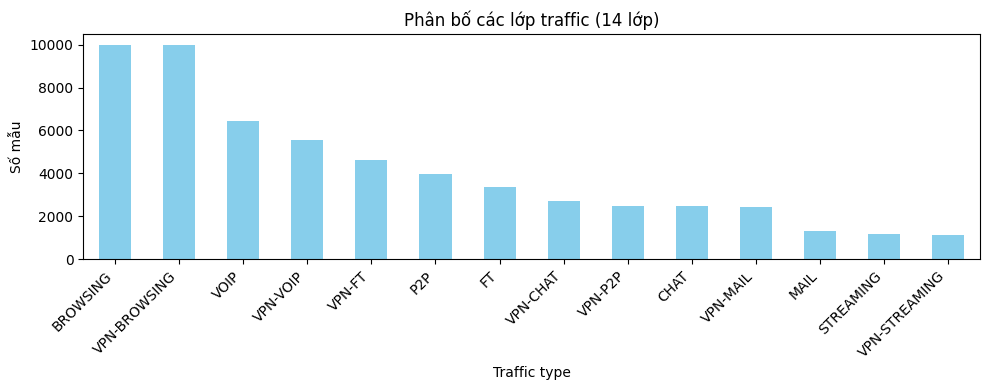

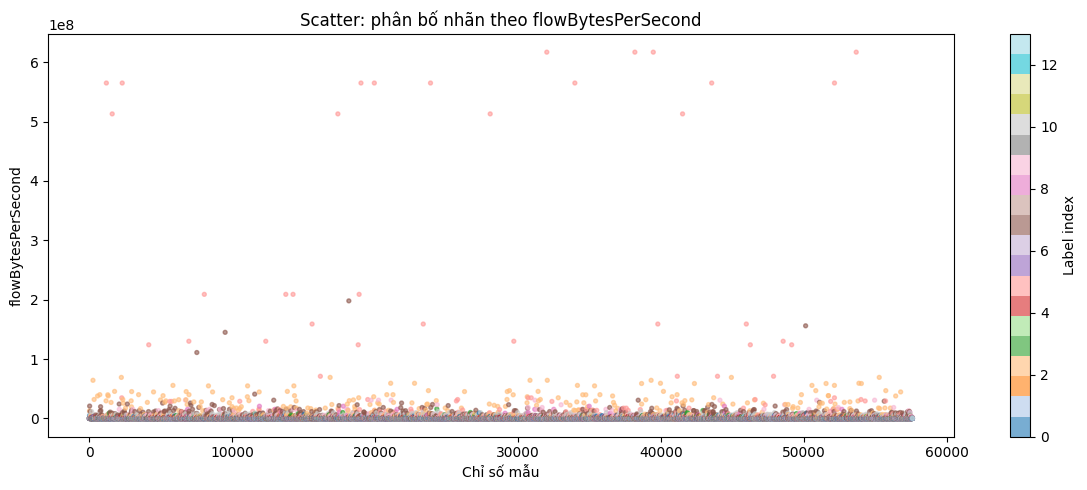

In [3]:
plt.figure(figsize=(10,4))
pd.Series(y_raw).value_counts().plot(kind="bar", color="skyblue")
plt.title("Phân bố các lớp traffic (14 lớp)")
plt.xlabel("Traffic type")
plt.ylabel("Số mẫu")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.scatter(
    range(len(df)),
    df["flowBytesPerSecond"],
    c=y,
    cmap="tab20",
    s=8,
    alpha=0.6
)
plt.title("Scatter: phân bố nhãn theo flowBytesPerSecond")
plt.xlabel("Chỉ số mẫu")
plt.ylabel("flowBytesPerSecond")
plt.colorbar(label="Label index")
plt.tight_layout()
plt.show()


# 4. Chia dữ liệu

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Số mẫu train / test:", X_train.shape[0], X_test.shape[0])

Số mẫu train / test: 46076 11520


# 5. Hàm đo thời gian và RAM

In [5]:
def train_and_measure(model, X_train, y_train):
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    return t1 - t0

def test_and_measure(model, X_test):
    t0 = time.time()
    y_pred = model.predict(X_test)
    t1 = time.time()
    return y_pred, (t1 - t0)

# 6. Định nghĩa mô hình

In [6]:
def build_knn(n_neighbors=5):
    return KNeighborsClassifier(n_neighbors=n_neighbors)

def build_c45():
    return DecisionTreeClassifier(random_state=42)

models = {
    "KNN": build_knn(5),
    "C45": build_c45()
}

# 7. Train + đánh giá + lưu kết quả

In [7]:
results = {}

for name, model in models.items():
    print(f"\n===== TRAINING {name} =====")

    train_time = train_and_measure(model, X_train, y_train)
    y_pred, test_time = test_and_measure(model, X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")

    print(f"Train time: {train_time:.4f} s")
    print(f"Test time : {test_time:.4f} s")
    print(classification_report(y_test, y_pred, target_names=label_names))

    results[name] = {
        "acc": acc,
        "f1": f1,
        "train_time": train_time,
        "test_time": test_time,
        "y_pred": y_pred
    }



===== TRAINING KNN =====
Train time: 0.0031 s
Test time : 2.1668 s
               precision    recall  f1-score   support

     BROWSING       0.70      0.82      0.76      2000
         CHAT       0.55      0.53      0.54       494
           FT       0.81      0.71      0.76       670
         MAIL       0.70      0.61      0.65       261
          P2P       0.82      0.84      0.83       797
    STREAMING       0.67      0.59      0.63       233
         VOIP       0.93      0.91      0.92      1287
 VPN-BROWSING       0.74      0.74      0.74      1997
     VPN-CHAT       0.54      0.41      0.47       542
       VPN-FT       0.70      0.62      0.66       923
     VPN-MAIL       0.80      0.88      0.84       486
      VPN-P2P       0.78      0.81      0.80       497
VPN-STREAMING       0.84      0.78      0.81       223
     VPN-VOIP       0.89      0.87      0.88      1110

     accuracy                           0.76     11520
    macro avg       0.75      0.72      0.73     1

# 8. Ma trận nhầm lẫn

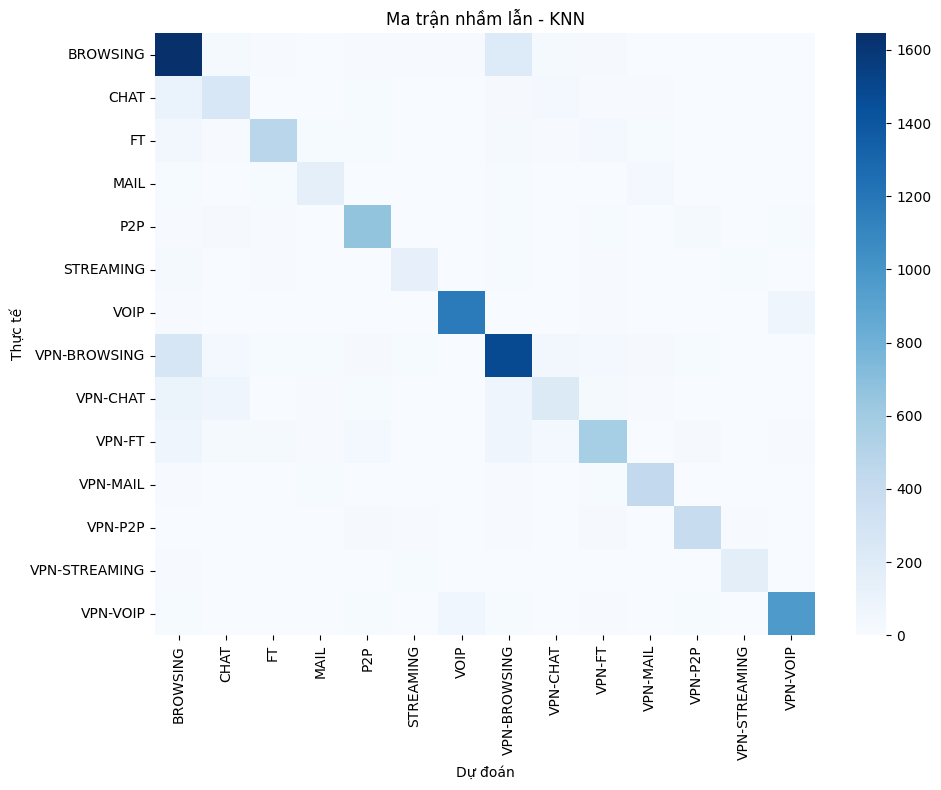

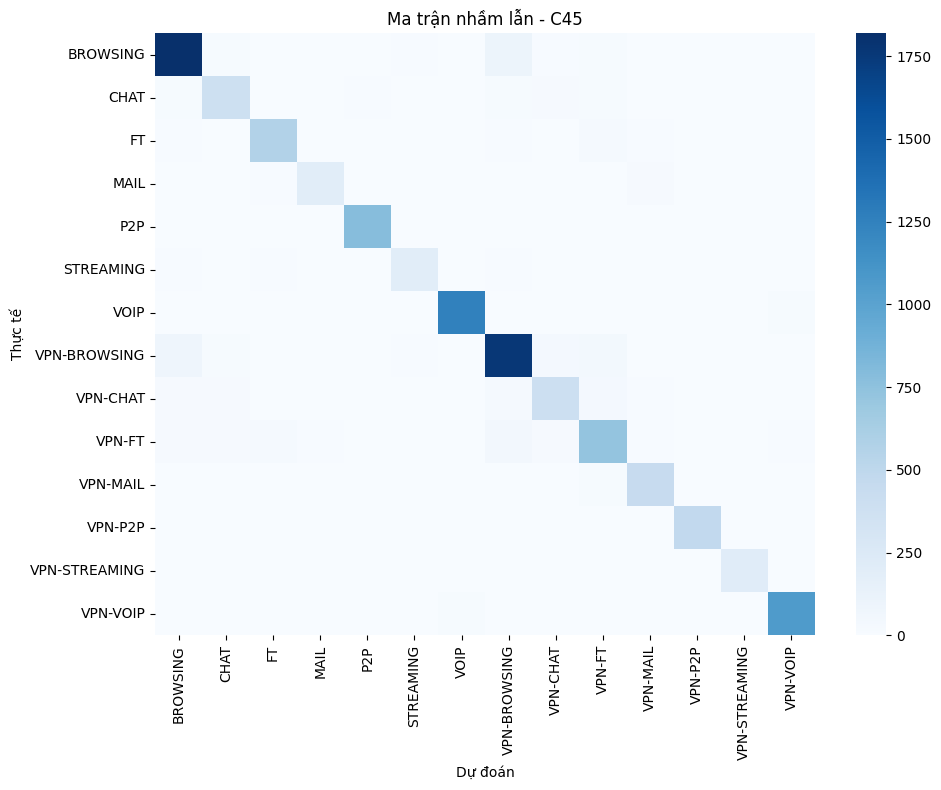

In [8]:
for name in results.keys():
    y_pred = results[name]["y_pred"]
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"Ma trận nhầm lẫn - {name}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.xticks(np.arange(len(label_names))+0.5, label_names, rotation=90)
    plt.yticks(np.arange(len(label_names))+0.5, label_names, rotation=0)
    plt.tight_layout()
    plt.show()

# 9. So sánh mô hình

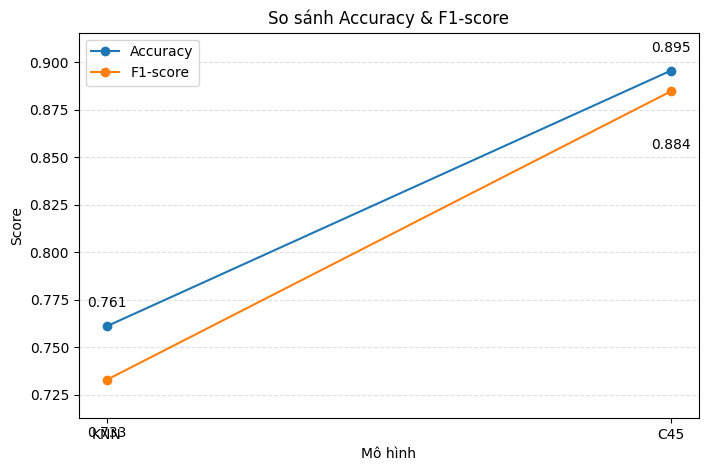

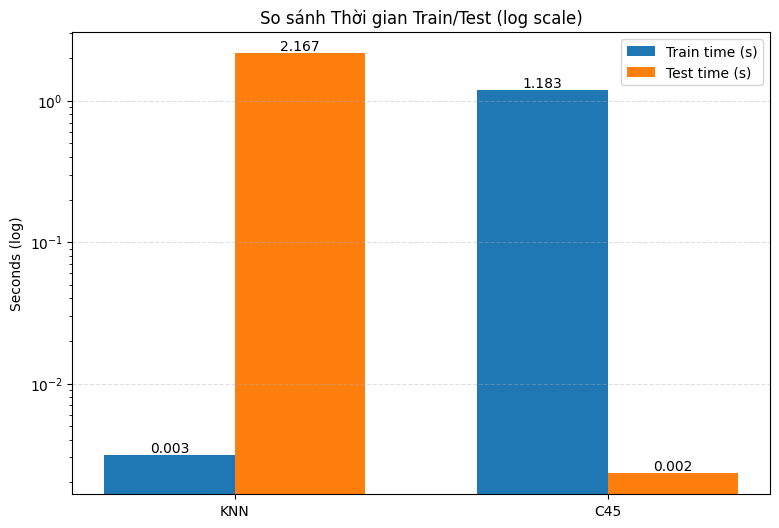

In [9]:
names = list(results.keys())
accs = [results[n]["acc"] for n in names]
f1s  = [results[n]["f1"] for n in names]

plt.figure(figsize=(8,5))
plt.plot(names, accs, marker='o', label="Accuracy")
plt.plot(names, f1s, marker='o', label="F1-score")

ymin = max(0.0, min(min(accs), min(f1s)) - 0.02)
ymax = min(1.0, max(max(accs), max(f1s)) + 0.02)
plt.ylim(ymin, ymax)

plt.title("So sánh Accuracy & F1-score")
plt.xlabel("Mô hình")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for i in range(len(names)):
    plt.text(i, accs[i] + 0.01, f"{accs[i]:.3f}", ha='center')
    plt.text(i, f1s[i] - 0.03, f"{f1s[i]:.3f}", ha='center')

plt.show()

train_times = [results[n]["train_time"] for n in names]
test_times  = [results[n]["test_time"] for n in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(9,6))
bars1 = plt.bar(x - width/2, train_times, width, label="Train time (s)")
bars2 = plt.bar(x + width/2, test_times, width, label="Test time (s)")

plt.xticks(x, names)
plt.yscale("log")
plt.title("So sánh Thời gian Train/Test (log scale)")
plt.ylabel("Seconds (log)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for b in bars1 + bars2:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h, f"{h:.3f}", ha='center', va='bottom')

plt.show()

# 10. Bảng tổng hợp

In [10]:
summary = pd.DataFrame(results).T
summary = summary[['acc','f1','train_time','test_time']]
summary = summary.rename(columns={
    'acc': 'Accuracy',
    'f1': 'F1_macro',
    'train_time': 'Train_time_s',
    'test_time': 'Test_time_s'
})

print("\n=== BẢNG TỔNG HỢP ML MULTI-CLASS ===")
print(summary)


=== BẢNG TỔNG HỢP ML MULTI-CLASS ===
     Accuracy  F1_macro Train_time_s Test_time_s
KNN  0.761024  0.732848     0.003116     2.16677
C45  0.895399   0.88449     1.182767    0.002317
